In [1]:
import os

import clean
import matplotlib.pyplot as plt
import numpy as np

os.environ["KERAS_BACKEND"] = "jax"
import keras
import keras_tuner
from keras import layers

In [ ]:
splits = clean.get_space_splits()
i_train, i_tune, i_test, t_train, t_tune, t_test = (
    splits[part] if part.startswith("t") else splits[part][:, 1:].reshape((-1, 10, 4))
    for part in ["i_train", "i_tune", "i_test", "t_train", "t_tune", "t_test"]
)
i_train: np.ndarray

In [6]:
@keras.saving.register_keras_serializable()
class InputNorm(layers.Layer):
    def __init__(self, n_inputs=4, **kwargs):
        super().__init__(**kwargs)
        self.mean = self.add_weight(
            shape=(1, 1, n_inputs),
            initializer="zero",
            trainable=False,
        )
        self.std = self.add_weight(
            shape=(1, 1, n_inputs),
            initializer="zero",
            trainable=False,
        )

    def adapt(self, data: np.ndarray):
        self.mean.assign(np.nanmean(data, axis=(0, 1)).reshape((1, 1, -1)))
        self.std.assign(np.nanstd(data, axis=(0, 1)).reshape((1, 1, -1)))

    def call(self, inp, **kwargs):
        return keras.ops.where(
            keras.ops.isnan(inp),
            0,
            keras.ops.divide(keras.ops.subtract(inp, self.mean), self.std),
        )

In [7]:
input_norm = InputNorm(name="input_norm")
input_norm.adapt(i_train)

output_denorm = layers.Normalization(
    axis=-1,
    invert=True,
    mean=t_train.mean(axis=0),
    variance=t_train.var(axis=0),
    name="output_denorm",
)

In [33]:
def directly_weighted_mse(y_true, y_pred):
    return keras.ops.mean(((y_true - y_pred) * (y_true / t_train.mean())) ** 2)

In [34]:
def build_model_lstm(hp: keras_tuner.HyperParameters):
    lstm_units = hp.Int("lstm_units", 1, 50, sampling="log")
    model = keras.Sequential(
        [
            layers.Input((10, 4), batch_size=50),
            input_norm,
            layers.Masking(name="mask"),
            layers.LSTM(
                lstm_units,
                name="lstm",
                dropout=hp.Float("dropout_rate", 0.001, 1, sampling="log")
                if hp.Boolean("dropout")
                else 0.0,
            ),
        ]
    )
    if hp.Boolean("post_layer"):
        post_units = hp.Int("lstm_units", 2, 50, sampling="log")
        model.add(layers.Dense(post_units, activation="relu"))

    model.add(layers.Dense(1, name="output"))
    model.add(output_denorm)

    lr = hp.Float("lr", min_value=0.0001, max_value=0.1, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=directly_weighted_mse,
        metrics=[keras.losses.MeanAbsolutePercentageError()],
    )
    return model

In [35]:
fit_args = dict(
    x=i_train,
    y=t_train,
    batch_size=500,
    epochs=30,
    validation_data=(i_tune, t_tune),
    callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=1)],
)

In [36]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_lstm,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=2,
    overwrite=False,
    seed=1,
    directory="keras_checkpoints",
    project_name="space_lstm_mse",
)
tuner.search_space_summary()

Reloading Tuner from keras_checkpoints/space_lstm_mse/tuner0.json
Search space summary
Default search space size: 5
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 50, 'step': None, 'sampling': 'log'}
dropout (Boolean)
{'default': False, 'conditions': []}
post_layer (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [37]:
tuner.search(**fit_args, verbose=1)

In [38]:
best_model = build_model_lstm(tuner.get_best_hyperparameters()[0])
history = best_model.fit(**fit_args, verbose=False)
best_model.save("../models/best_lstm_dwm.keras")

In [12]:
best_model = keras.models.load_model("../models/best_lstm.keras")

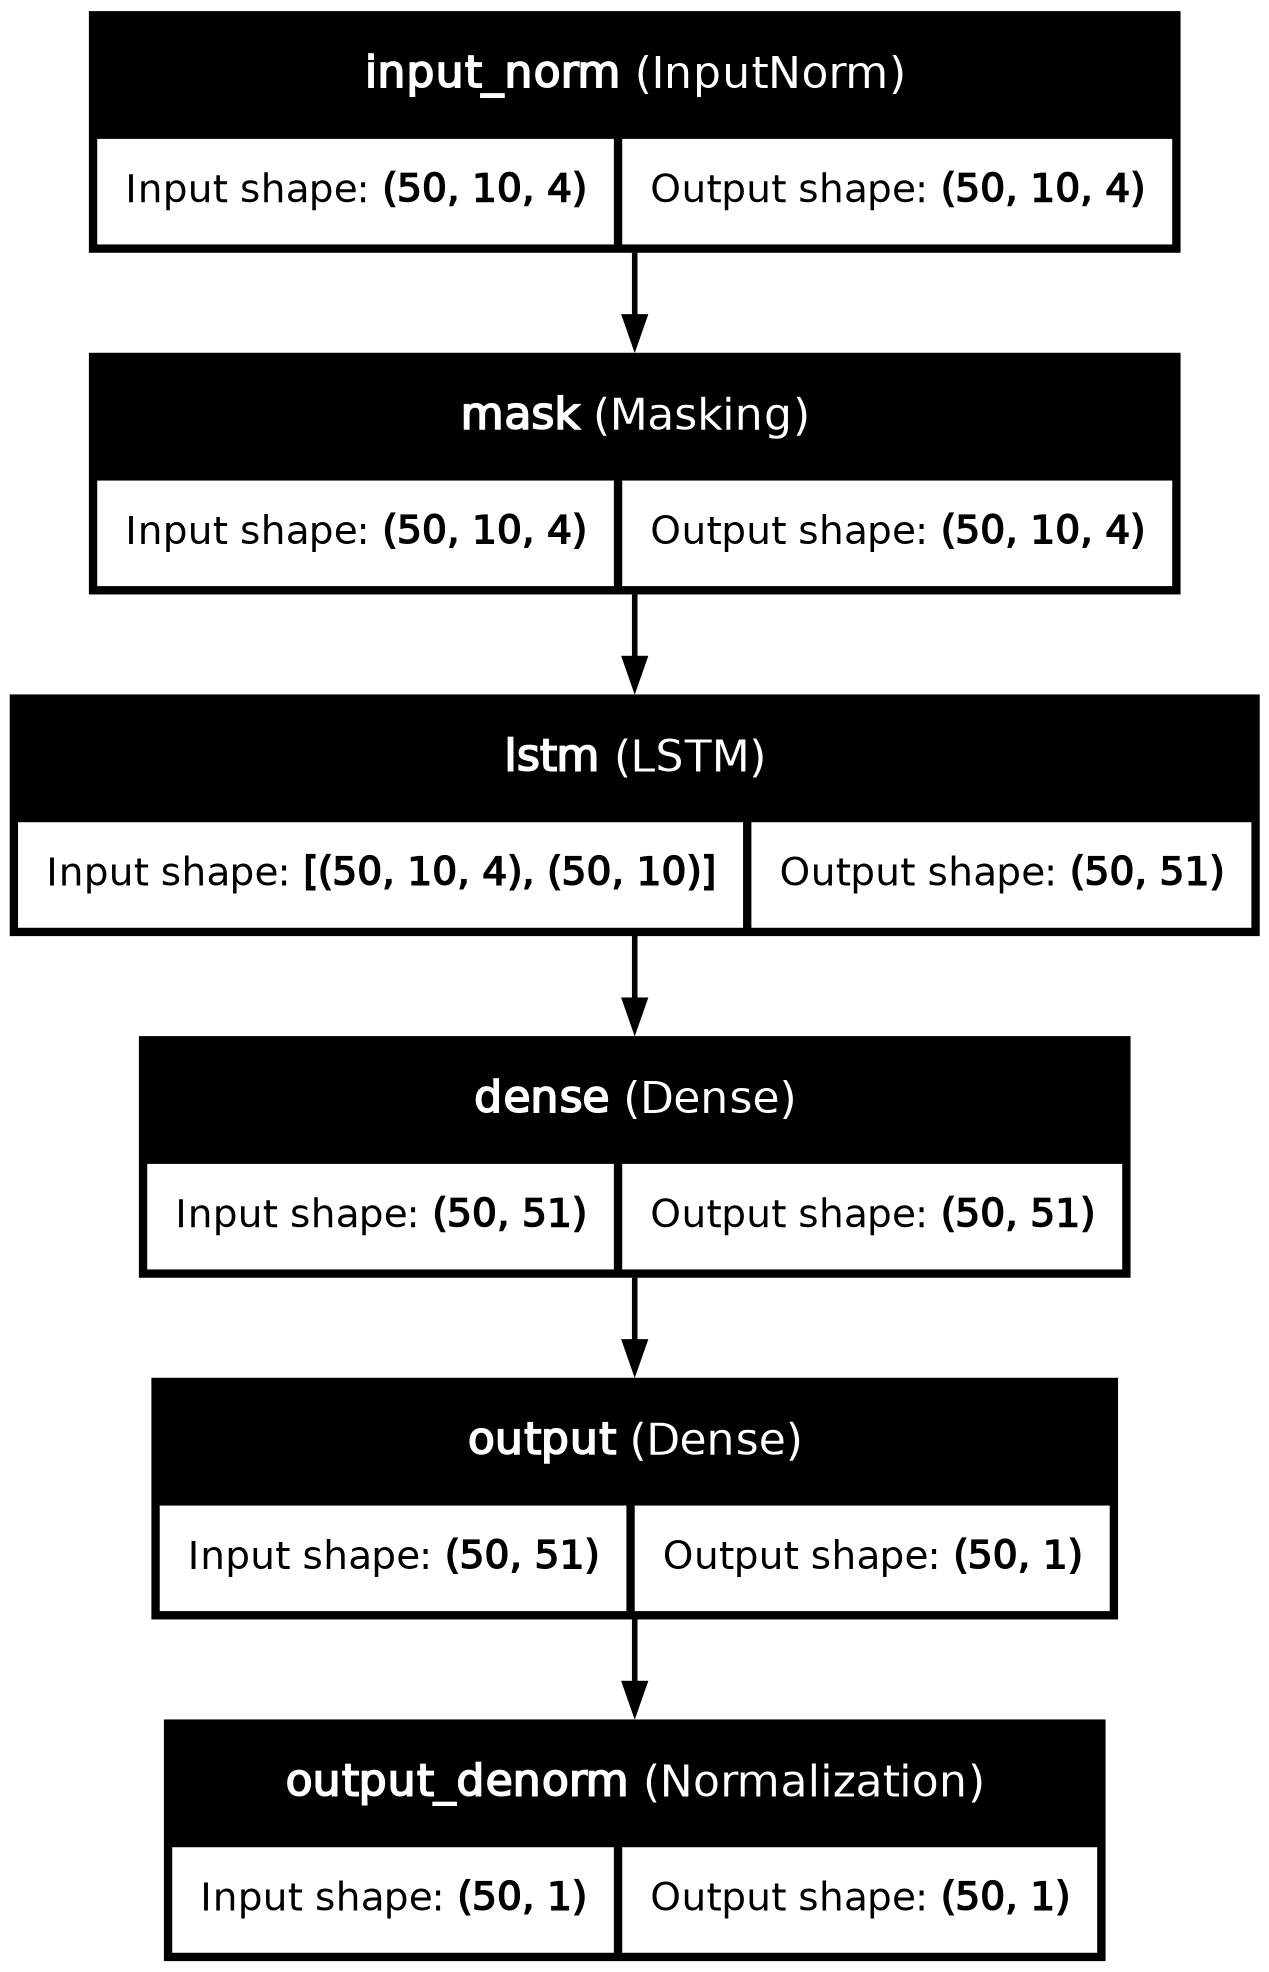

In [13]:
keras.utils.plot_model(
    best_model, to_file="lstm.png", show_shapes=True, show_layer_names=True
)

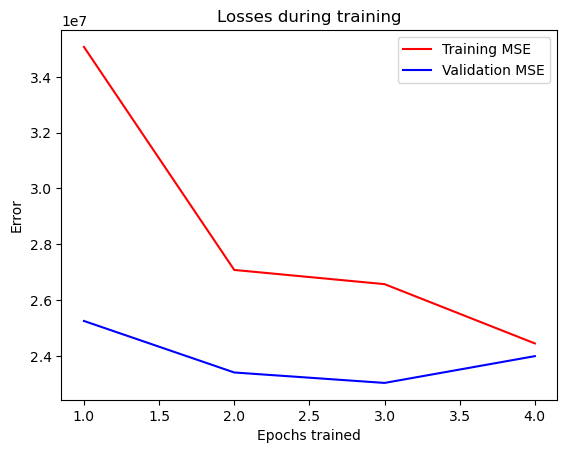

In [24]:
x = range(1, 5)

plt.plot(x, history.history["loss"], color="red", label="Training MSE")

plt.plot(x, history.history["val_loss"], color="blue", label="Validation MSE")
plt.legend()
plt.title("Losses during training")
plt.xlabel("Epochs trained")
plt.ylabel("Error")
# plt.ylim((0, 1000))
plt.show()

In [ ]:
np.save(clean.data_dir("pred/lstm_wgh.npy"), best_model(i_test))

In [15]:
results = best_model.evaluate(i_test, t_test, batch_size=5000)

print("RMSE:", np.sqrt(results[0]))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 503.7350 - mean_absolute_percentage_error: 541.6282
RMSE: 22.483255895316784


In [48]:
print(
    "RMSE (DWM):",
    np.sqrt(
        keras.losses.mean_squared_error(t_test.flatten(), best_model(i_test).flatten())
    ),
)

RMSE (DWM): 47.634666
